In [1]:
!pip install wandb -qU

In [4]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import wandb
from tensorflow import keras
from imblearn.over_sampling import SMOTE

# Librerías adicionales
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import random

In [5]:
wandb.login()

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [6]:
#IMPORTAMOS LOS DATOS (MODIFICAR RUTA)
df = pd.read_csv("/content/diabetes.csv", delimiter=",")

In [7]:
df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


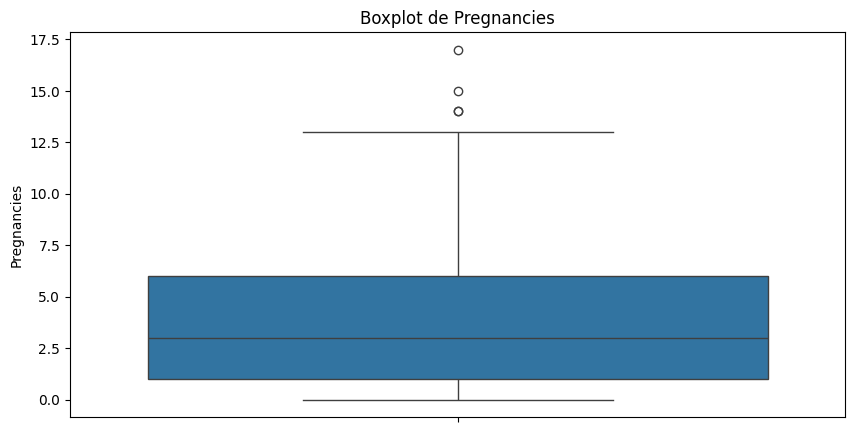

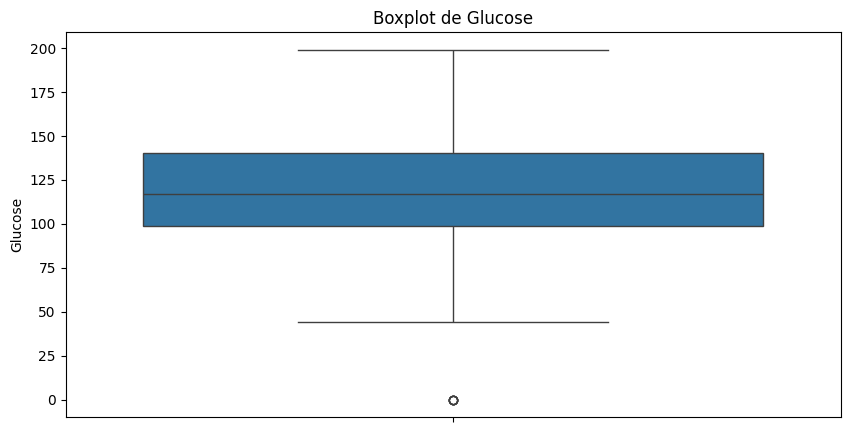

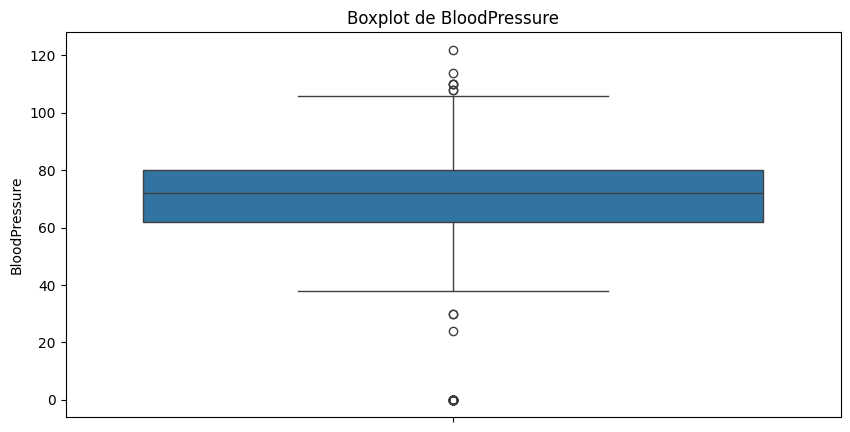

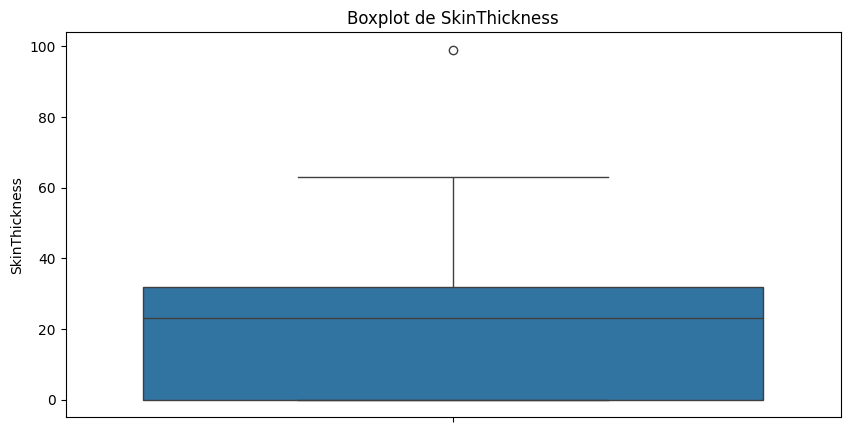

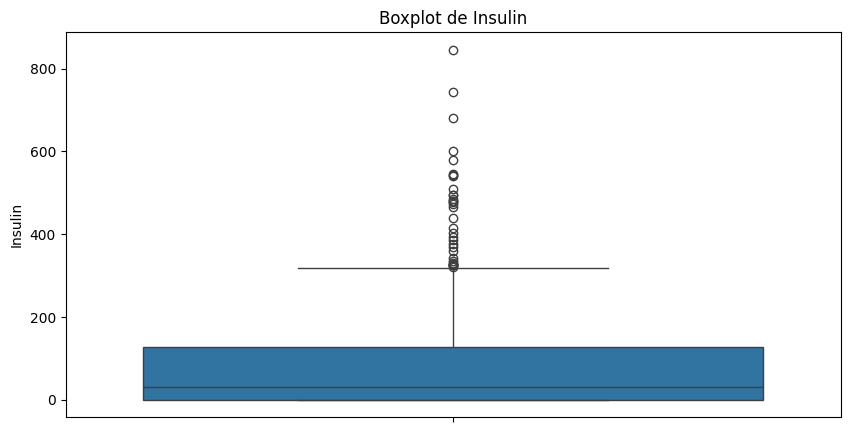

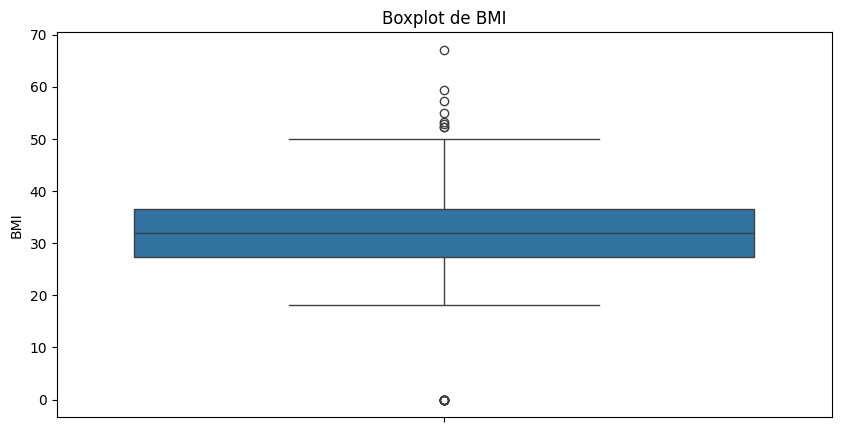

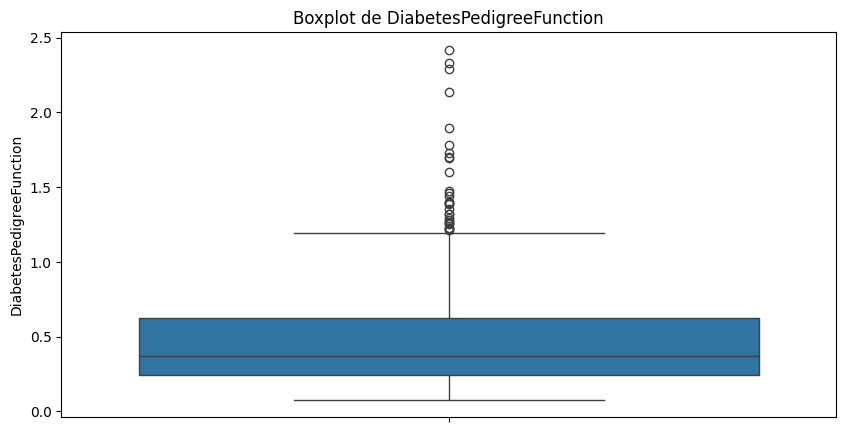

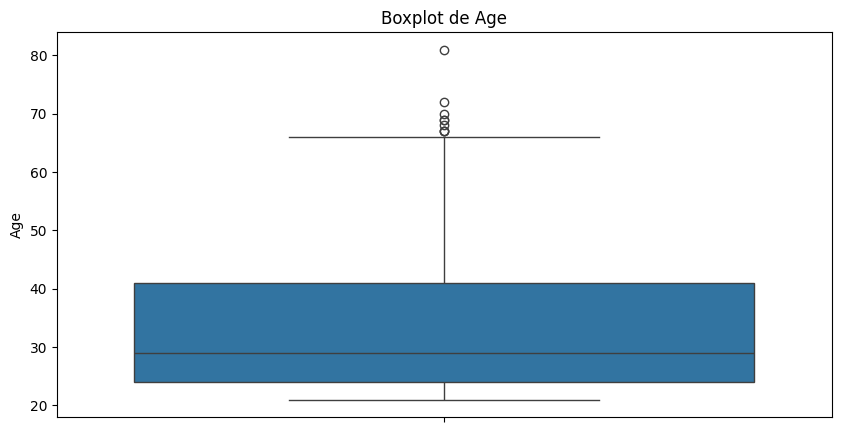

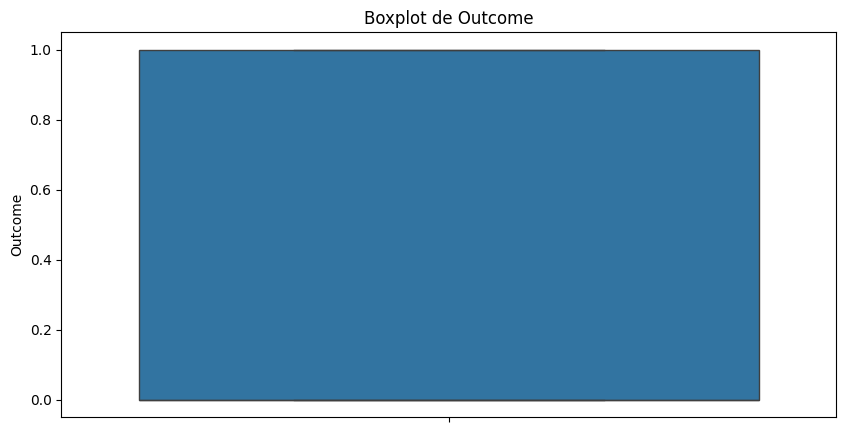

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Crear un boxplot para cada columna numérica
for column in df.select_dtypes(include=[np.number]).columns:
    plt.figure(figsize=(10, 5))
    sns.boxplot(df[column])
    plt.title(f'Boxplot de {column}')
    plt.show()

In [8]:
import numpy as np

# Definir función para eliminar outliers usando desviación estándar
def remove_outliers_std(df, num_std=3):
    # Calcular la media y la desviación estándar para cada columna
    mean = df.mean()
    std = df.std()

    # Filtrar los outliers: Mantener solo los valores que están dentro del rango de ±num_std desviaciones estándar
    df_filtered = df[(np.abs((df - mean) / std) < num_std).all(axis=1)]
    return df_filtered

# Aplicar la función a tu dataframe
df_sin_outliers_std = remove_outliers_std(df)

# Mostrar los resultados
print(f"Número de filas antes de eliminar outliers: {df.shape[0]}")
print(f"Número de filas después de eliminar outliers: {df_sin_outliers_std.shape[0]}")

Número de filas antes de eliminar outliers: 768
Número de filas después de eliminar outliers: 688


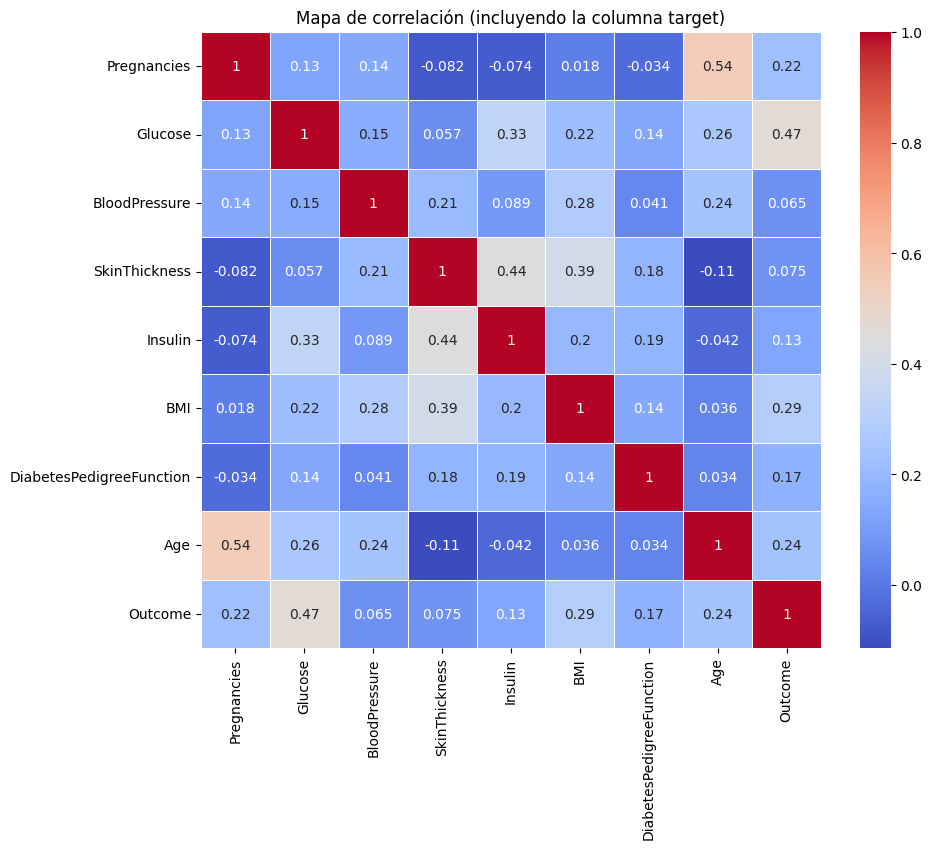

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calcular la matriz de correlación, incluye todas las columnas numéricas
correlation_matrix = df.corr()

# Crear el mapa de calor (heatmap) con todas las columnas, incluida la target
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Mapa de correlación (incluyendo la columna target)')
plt.show()

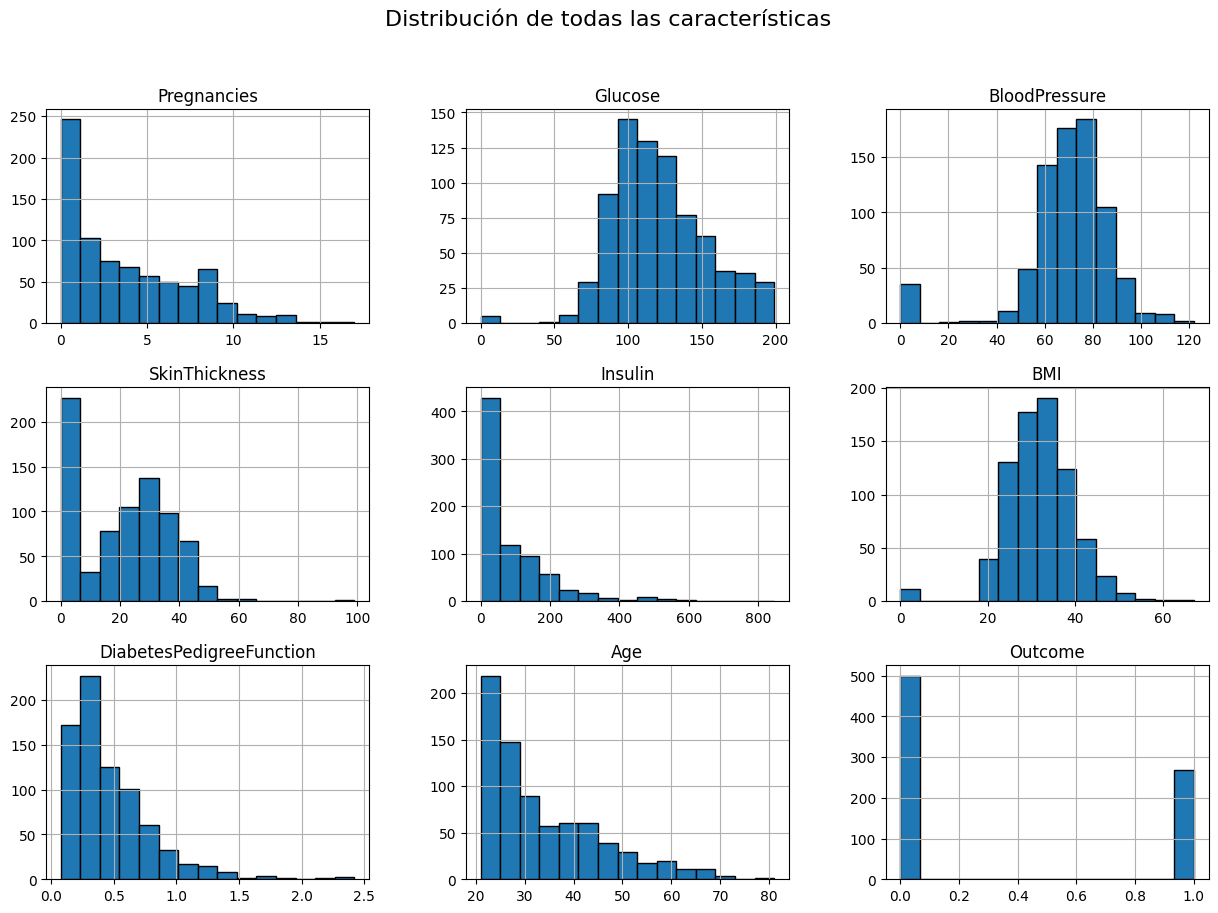

In [10]:
df.hist(bins=15, figsize=(15, 10), edgecolor='black')
plt.suptitle('Distribución de todas las características', size=16)
plt.show()

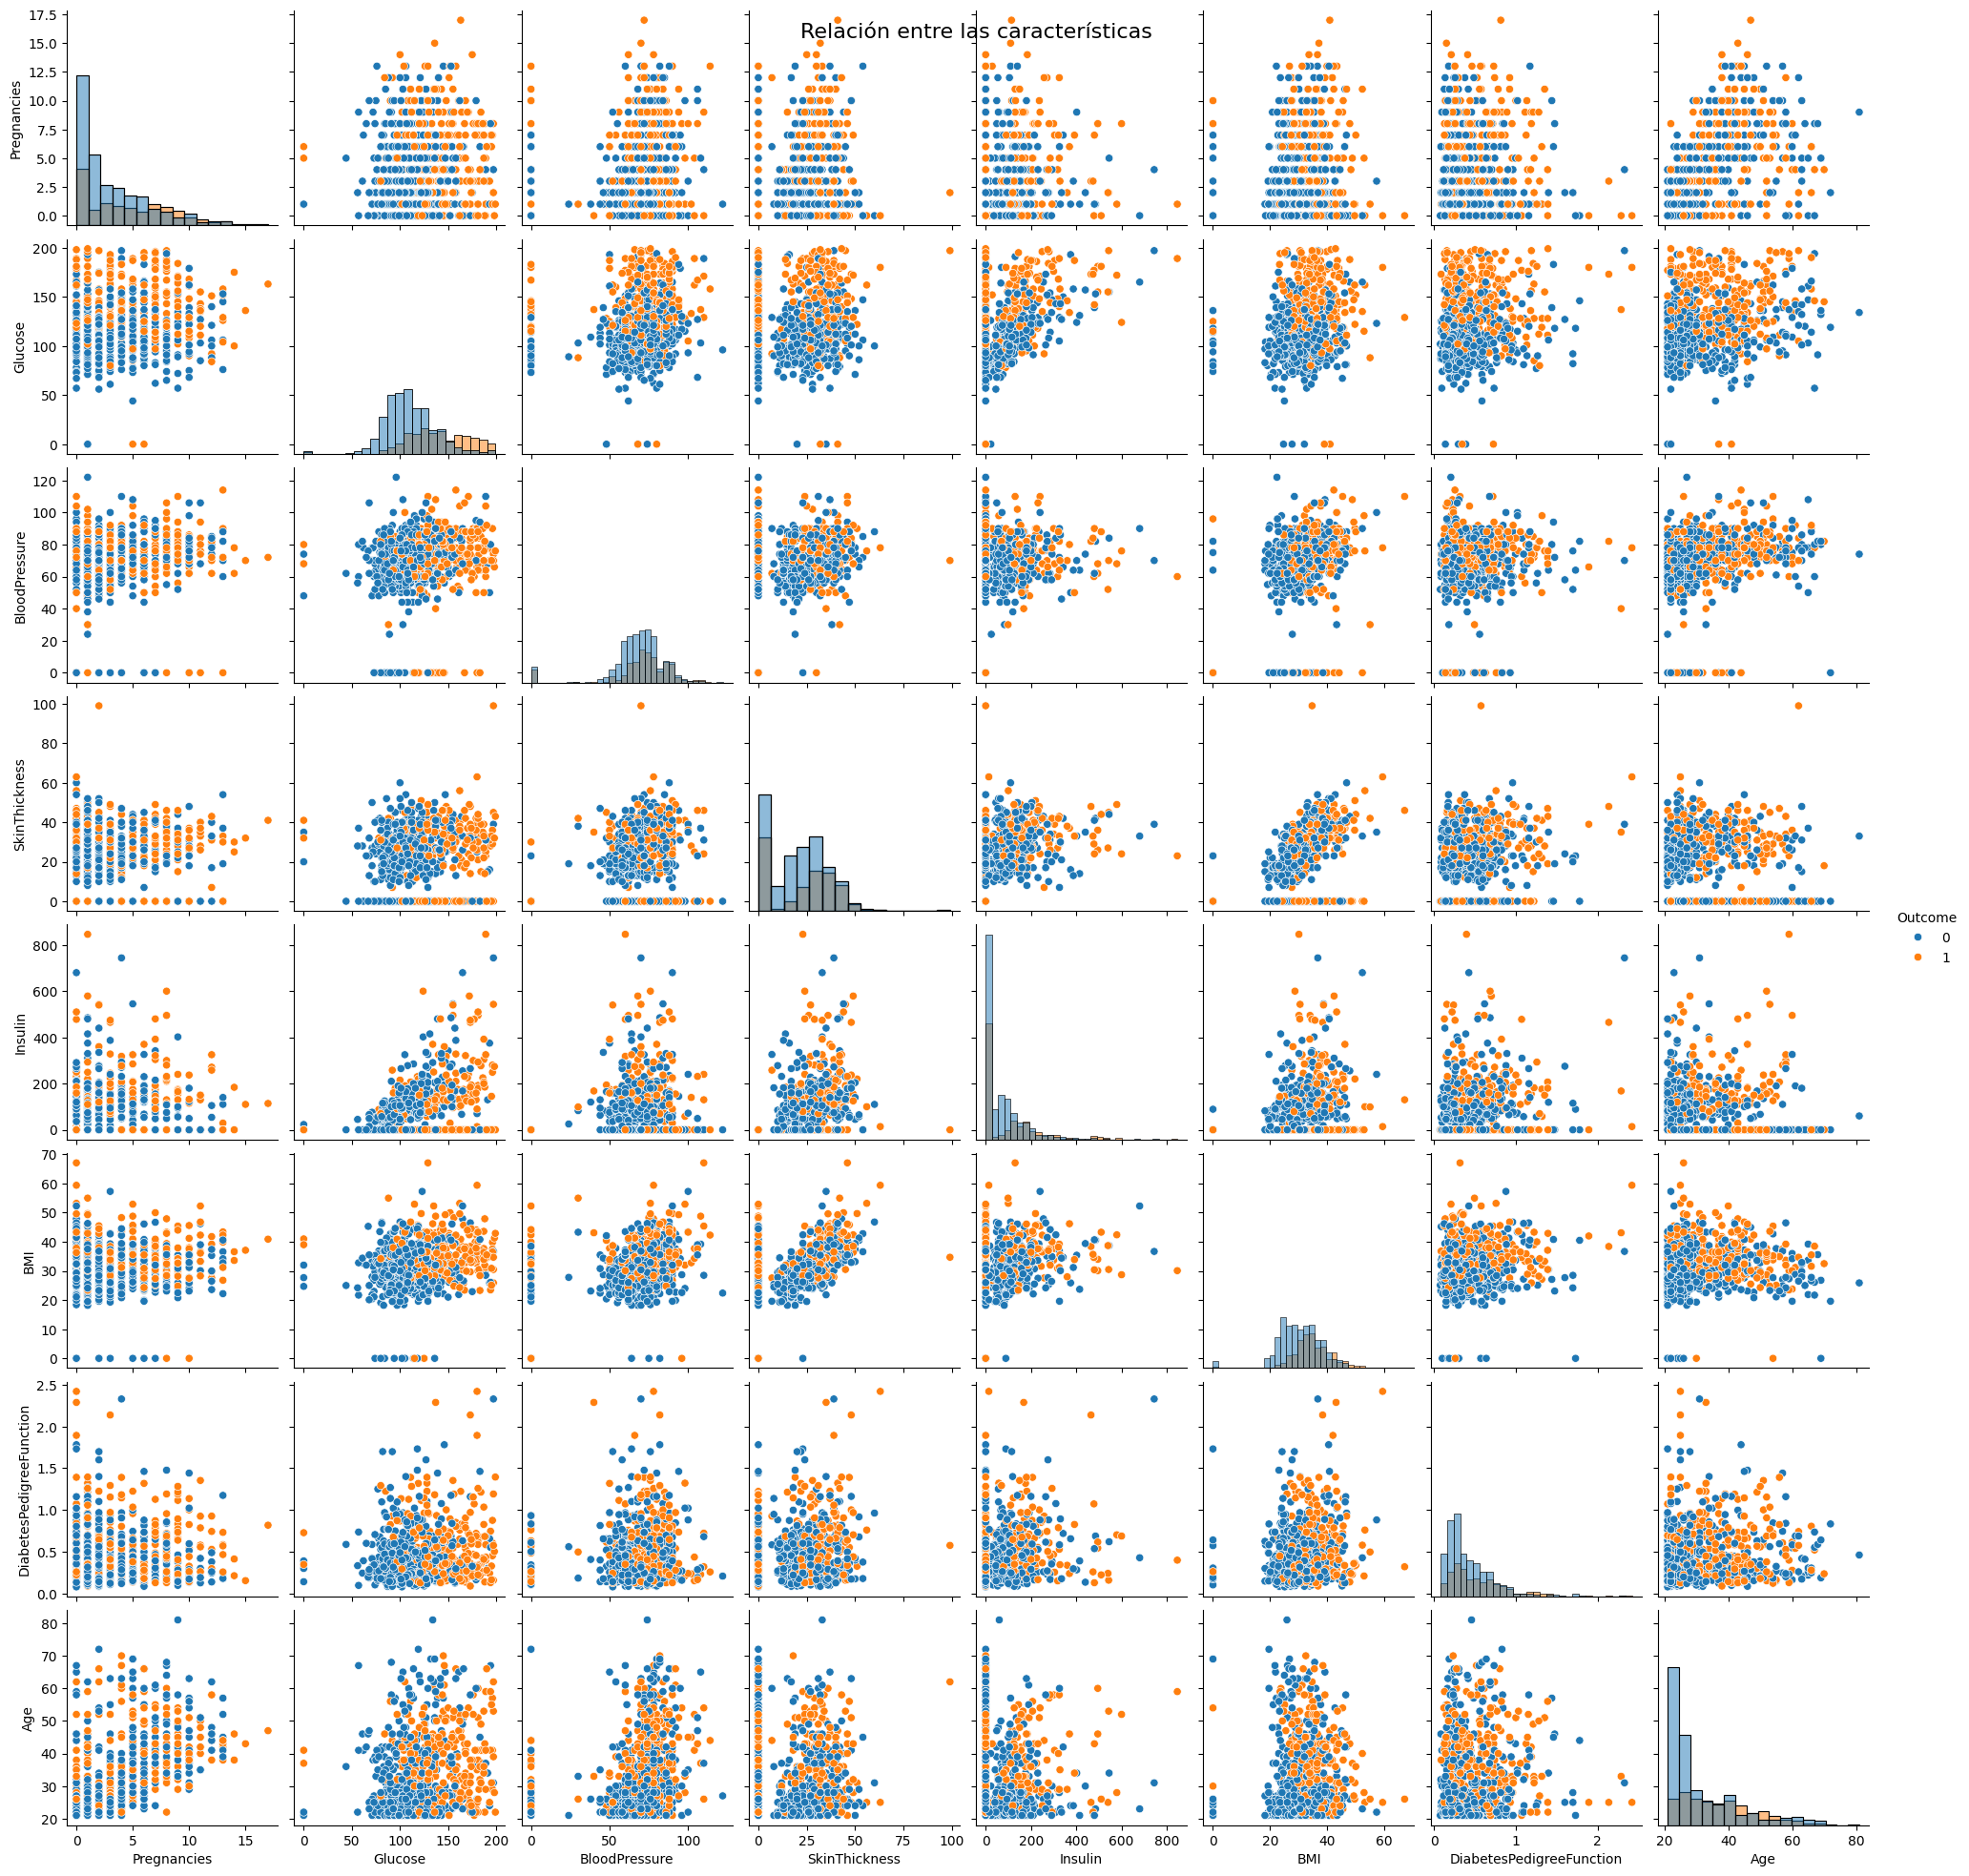

In [ ]:
# Diagrama de dispersión de pares entre todas las variables
sns.pairplot(df, hue='Outcome', diag_kind='hist')  # Cambia 'target' por el nombre de tu columna objetivo
plt.suptitle('Relación entre las características', size=16)
plt.show()


In [11]:
# Asumimos que la última columna es la etiqueta binaria
X = df.iloc[:, :-1].values  # Todas las columnas menos la última (características)
y = df.iloc[:, -1].values   # Última columna (etiquetas)

In [12]:
# Dividimos el dataset en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [13]:
# Aplicar MinMaxScaler para escalar los datos entre 0 y 1
#scaler = MinMaxScaler()
#X_train_scaled = scaler.fit_transform(X_train)
#X_test_scaled = scaler.transform(X_test)

#from sklearn.preprocessing import RobustScaler

#scaler = RobustScaler()
#X_train_scaled = scaler.fit_transform(X_train)
#X_test_scaled = scaler.transform(X_test)

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [14]:
# Contar los valores de la columna 'tu_columna'
conteo = df['Outcome'].value_counts()

# Mostrar el conteo de 0 y 1
print(conteo)

Outcome
0    500
1    268
Name: count, dtype: int64


In [15]:
# Aplicar SMOTE para balancear el dataset de entrenamiento
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

In [16]:
# Definir el número de experimentos simulados
total_runs = 5

In [17]:
# Ejecutar múltiples experimentos
for run in range(total_runs):
    # Iniciar un nuevo experimento en wandb
    wandb.init(
        project="prueba_diabetes",
        name=f"experiment_{run}",
        config={
            "learning_rate": 0.01,
            "architecture": "Simple Neural Network with SMOTE",
            "dataset": "Custom CSV",
            "epochs": 10,
            "dropout_rate": 0.3,
        }
    )

    config = wandb.config

wandb: Currently logged in as: nicodriguez3 (nicodriguez3-n-a). Use `wandb login --relogin` to force relogin


In [18]:
# Crear el modelo secuencial de red neuronal
model = Sequential()
model.add(Dense(16, activation='relu', input_shape=(X_train_resampled.shape[1],))) #capa culta 16 neuronas
model.add(Dropout(0.3))
model.add(Dense(8, activation='relu', input_shape=(X_train_resampled.shape[1],))) #capa culta 16 neuronas
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))  # Capa de salida (clasificación binaria)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [19]:
# Compilar el modelo con un optimizador, función de pérdida y métrica
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=config.learning_rate),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

In [20]:
# Entrenar el modelo y registrar el historial
history = model.fit(X_train_resampled, y_train_resampled,
                    epochs=wandb.config.epochs,
                    validation_data=(X_test, y_test),
                    batch_size=32)

Epoch 1/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.6072 - loss: 0.7025 - val_accuracy: 0.3463 - val_loss: 44.3993
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6996 - loss: 0.5702 - val_accuracy: 0.3463 - val_loss: 81.4598
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7826 - loss: 0.5127 - val_accuracy: 0.3463 - val_loss: 81.6453
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7441 - loss: 0.5040 - val_accuracy: 0.3463 - val_loss: 76.5865
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7451 - loss: 0.4914 - val_accuracy: 0.3463 - val_loss: 63.7760
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7101 - loss: 0.5110 - val_accuracy: 0.3463 - val_loss: 86.0265
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7505 - loss: 0.4986 - val_accuracy: 0.3463 - val_loss: 72.9126
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7591 - loss: 0.4868 - val_accuracy: 0.3463 - v

In [21]:
# Registrar los resultados en wandb
wandb.log({'loss': history.history['loss'][-1], 'val_loss': history.history['val_loss'][-1], 'accuracy': history.history['accuracy'][-1], 'val_accuracy': history.history['val_accuracy'][-1]})

In [22]:
# Finalizar el experimento en wandb
wandb.finish()

accuracy,▁
loss,▁
val_accuracy,▁
val_loss,▁
accuracy,0.75645
loss,0.49862
val_accuracy,0.34632
val_loss,69.48561
